In [1]:
cd ../../

/workspaces/research/motor-decoding


In [2]:
import json
import sys
from collections import Counter
from itertools import cycle
from pathlib import Path

import dabest
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne_bids.read import read_raw_bids
from mne_bids import BIDSPath
from rerf.rerfClassifier import rerfClassifier
from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from tqdm import tqdm

from mtsmorf.io.read import read_dataset, read_label, read_trial, get_trial_info
from mtsmorf.io.utils import NumpyEncoder
from mtsmorf.war_exp.cv import nested_cv_fit, cv_fit, bootstrap_fit

from mtsmorf.move_exp.plotting import (
    plot_signals,
    plot_roc_multiclass_cv,
    plot_feature_importances,
    plot_cv_indices
)

# plt.style.use(['science', 'ieee', 'no-latex'])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# bids_root = Path("/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/data/efri/")

tmin, tmax = (-0.75, 1.25)

bids_root = Path("/workspaces/research/mnt/data/efri")
derivatives_path = (
    bids_root / "derivatives" / "preprocessed" / f"tmin={tmin}-tmax={tmax}" / "low-pass=1000Hz-downsample=500"
)

# subject identifiers
subject = "efri07"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".vhdr", root=bids_root)

In [4]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

Out of 98 trials, there were 96 successful trials in /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 98 trials, there were 96 successful trials in /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.


## Band-pass filter (70-200 Hz)
- Standard band-pass filter on time-domain signal (70-200 Hz)
- Results: Classifier performance was at trivial levels on 5-fold stratified CV

In [48]:
# get preprocessed epochs data
fname = os.path.splitext(bids_path.basename)[0] + "-epo.fif"
fpath = derivatives_path / subject / fname
epochs = mne.read_epochs(fpath, proj=False, preload=True)
hi_gamma = epochs.filter(l_freq=70, h_freq=200)
hi_gamma = hi_gamma.drop(unsuccessful_trial_inds)

# get shape of data
hi_gamma_data = hi_gamma.get_data()
ntrials, nchs, nsteps = hi_gamma_data.shape
print(f'epochs_data.shape = {hi_gamma_data.shape}')

epochs_data.shape = (76, 75, 1000)


In [49]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = hi_gamma_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

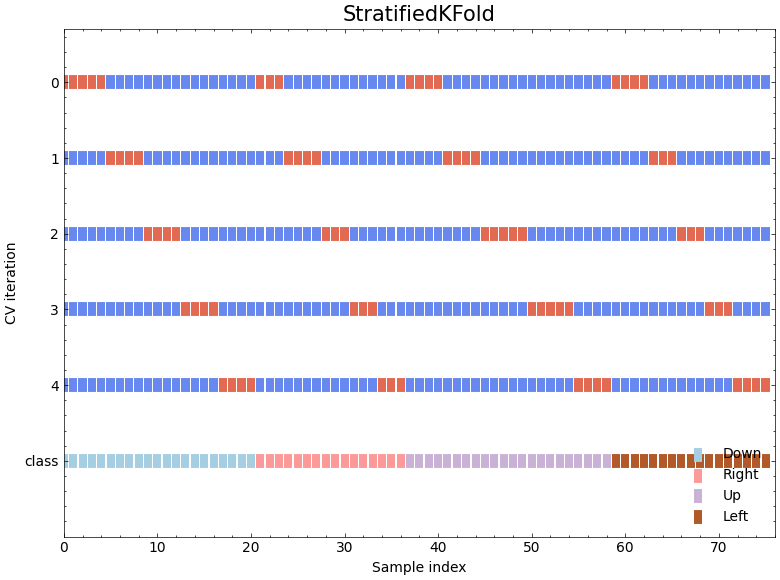

In [50]:
# Perform K-Fold cross validation
n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
argsort_inds = np.argsort(y)
plot_cv_indices(cv, X[argsort_inds], y[argsort_inds], ax, n_splits, lw=10)
ax.legend(loc='lower right')
fig.tight_layout();

In [51]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

stratified_kf_scores = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

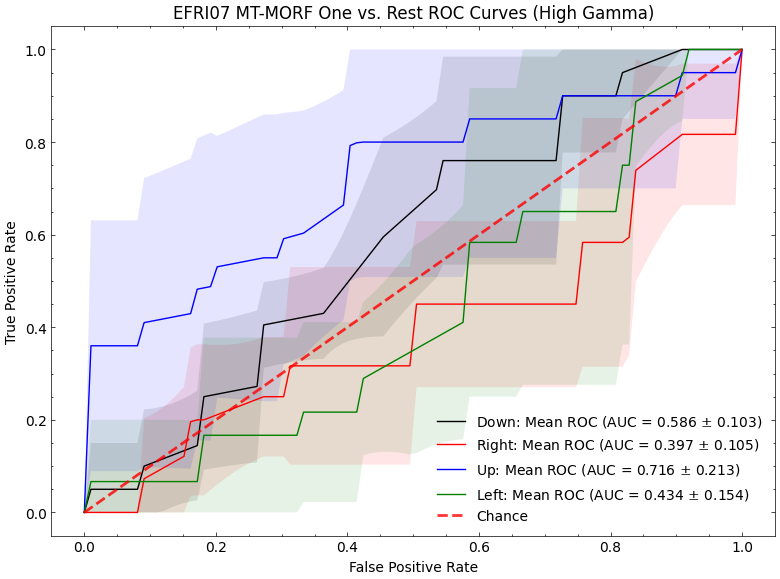

In [52]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores["test_predict_proba"],
    X,
    y,
    stratified_kf_scores["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (High Gamma)",
)
ax.legend(loc="lower right")
fig.tight_layout();

## Analyzing time-domain signal

In [54]:
# get preprocessed epochs data
fname = os.path.splitext(bids_path.basename)[0] + "-epo.fif"
fpath = derivatives_path / subject / fname

epochs = mne.read_epochs(fpath, preload=True)
epochs = epochs.drop(unsuccessful_trial_inds)

In [6]:
drop_inds = {k : np.where(labels != k)[0] for k in np.unique(labels)}
label_names = {0: "Down", 1: "Right", 2: "Up", 3: "Left"}

In [ ]:
epochs_by_direction = {}
for k, v in drop_inds.items():
    tmp = epochs.copy()
    tmp.drop(v)
    epochs_by_direction[k] = tmp

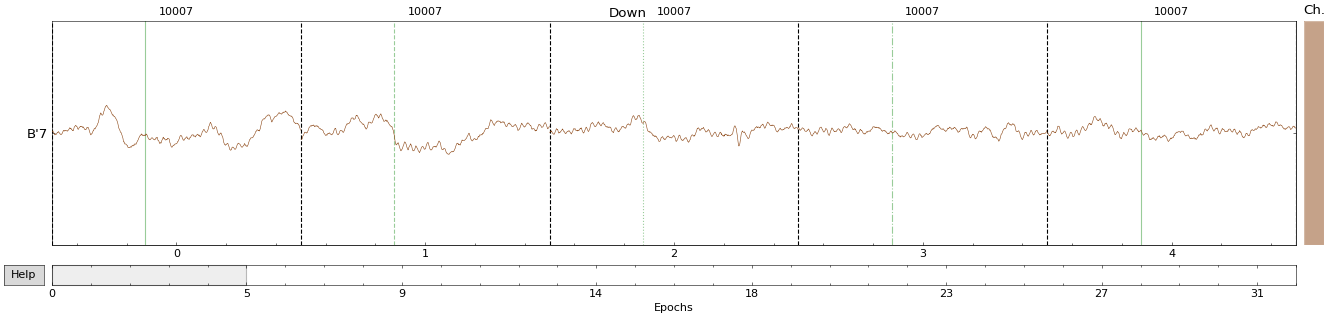

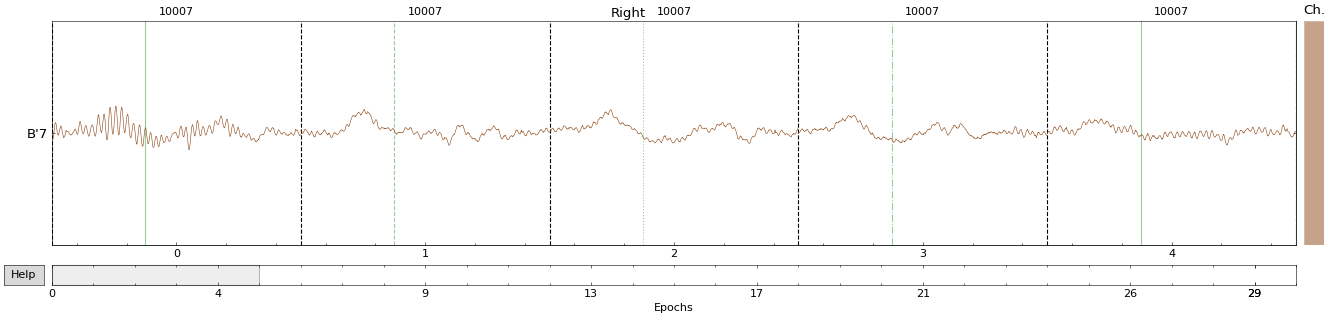

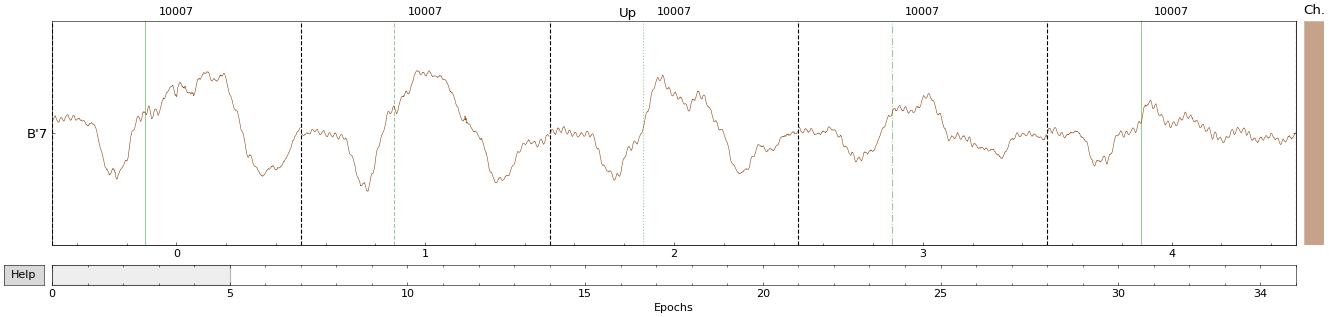

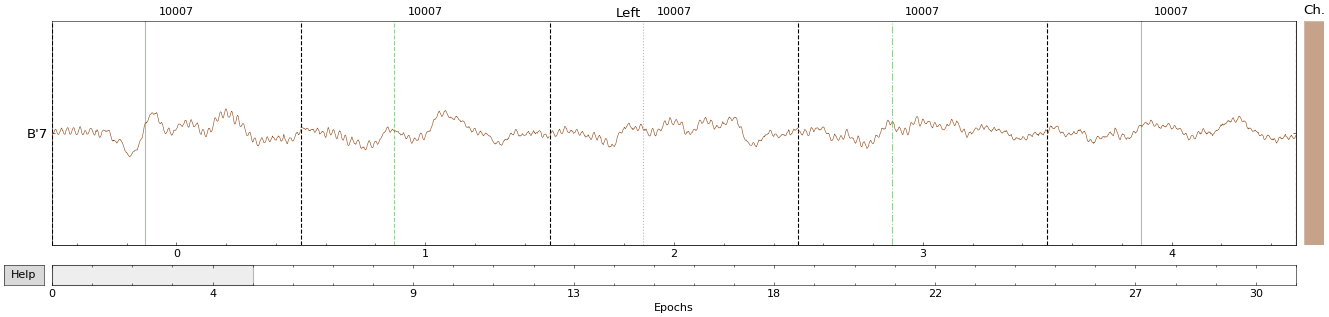

In [13]:
picks = ["B7"]
for k, ep in epochs_by_direction.items():
    fig = ep.plot(
        picks=picks,
        scalings=dict(seeg=1e2), 
        n_epochs=5,
        show=False,
        title=label_names[k],
    )
    fig.suptitle(label_names[k])
    fig.set_size_inches(18, 4, forward=True)
    plt.show()

Not setting metadata
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


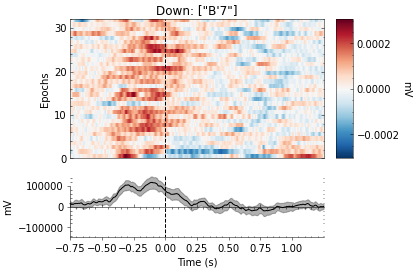

Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


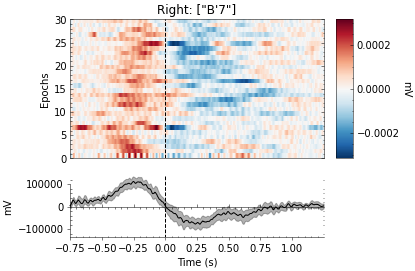

Not setting metadata
Not setting metadata
35 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


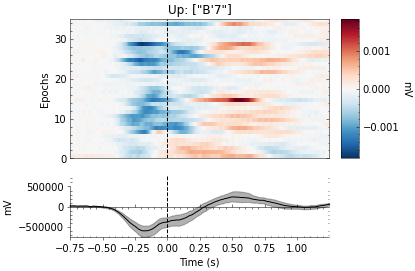

Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


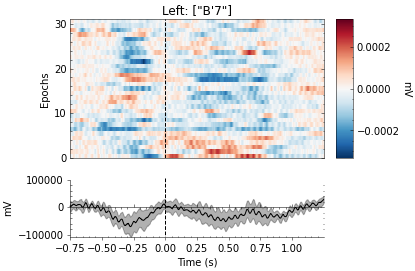

In [14]:
# fig, axs = plt.subplots(nrows=3, ncols=4, dpi=100)

for i, (k, ep) in enumerate(epochs_by_direction.items()):
    ep.plot_image(
        picks=picks,
        scalings=dict(seeg=1e-6),
        title=f"{label_names[k]}: {picks}"
    );
plt.show()

## Computing Spectral Power for 70-200Hz
- Tried training only on median frequency bin (performs near chance)
- Likely because we dropped a great deal of spectral content

In [7]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

Not setting metadata


In [8]:
hi_gamma = power.data

hi_gamma.shape

(76, 75, 10, 334)

No baseline correction applied
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


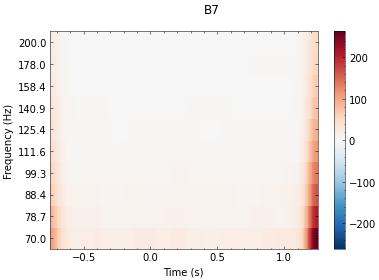

In [11]:
power.average().plot(["B7"]);

## Average across freqs

In [12]:
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

avg_freq_data.shape

(76, 75, 250)

In [13]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


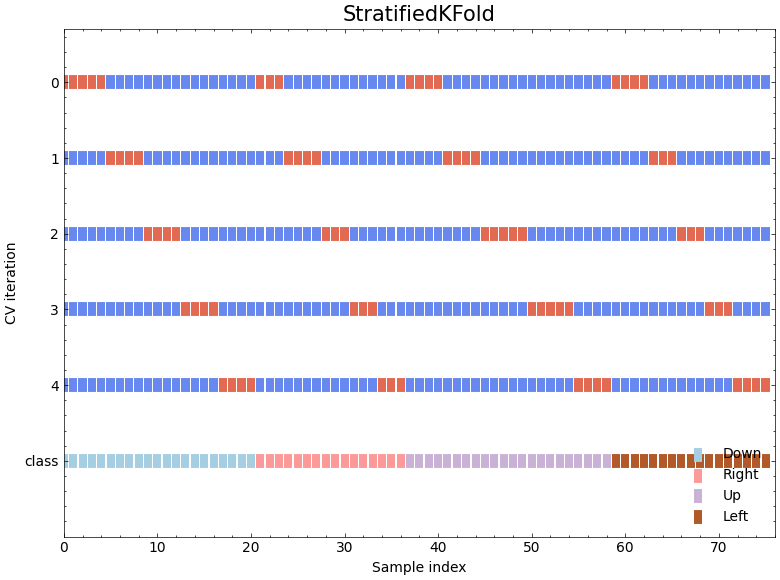

In [14]:
# Perform K-Fold cross validation
n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
argsort_inds = np.argsort(y)
plot_cv_indices(cv, X[argsort_inds], y[argsort_inds], ax, n_splits, lw=10)
ax.legend(loc='lower right')
fig.tight_layout();

In [15]:
metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_freq_avg = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_freq_avg.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


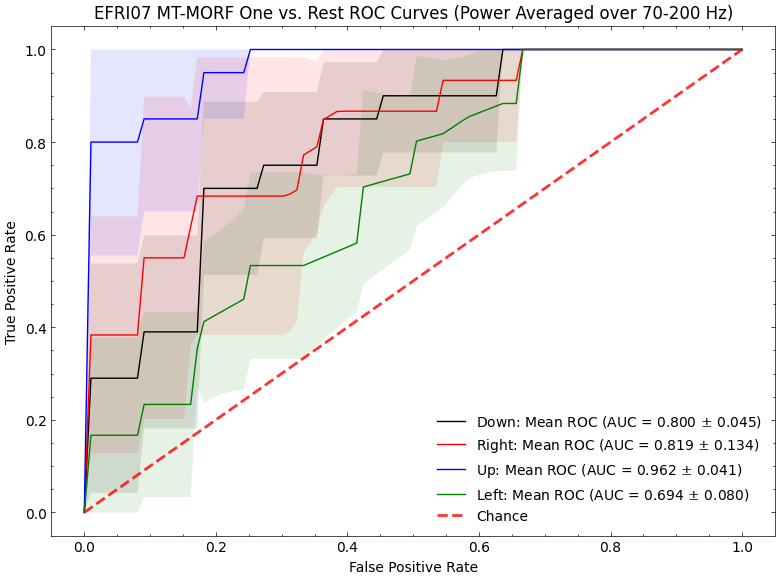

In [16]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_freq_avg["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_freq_avg["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

## Increase granularity of freq dimension

In [17]:
nfreqs = 30
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

Not setting metadata


In [18]:
hi_gamma = power.data
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_more_freq = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_more_freq.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

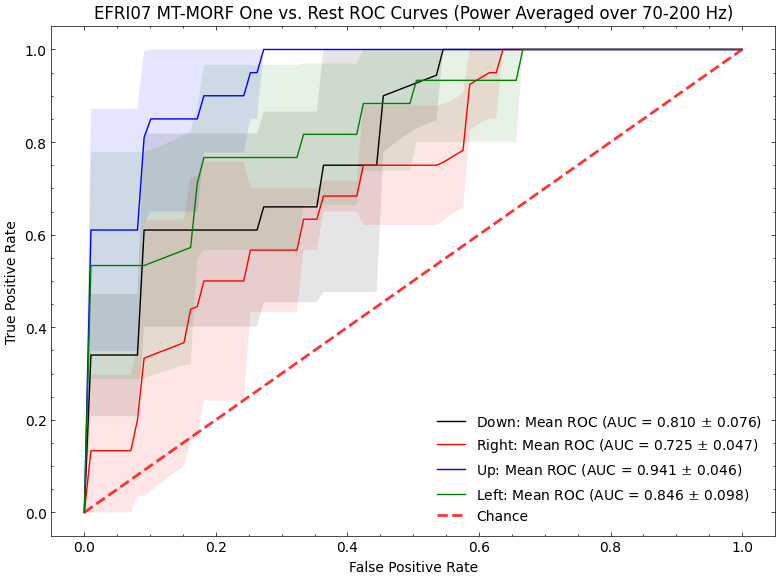

In [19]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_more_freq["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_more_freq["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

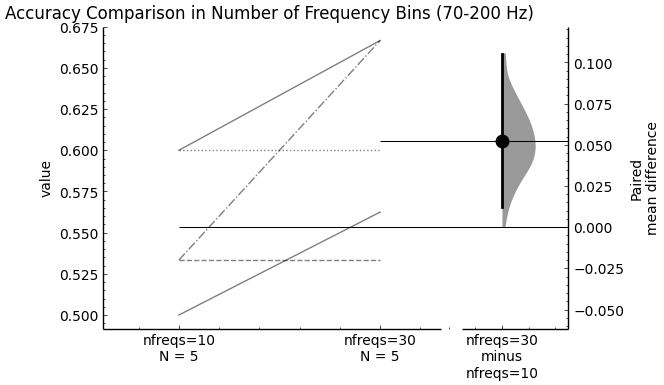

In [20]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "nfreqs=10": stratified_kf_scores_freq_avg["test_accuracy"],
    "nfreqs=30": stratified_kf_scores_more_freq["test_accuracy"],
})

my_data = dabest.load(df, idx=("nfreqs=10", "nfreqs=30"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="Accuracy Comparison in Number of Frequency Bins (70-200 Hz)");

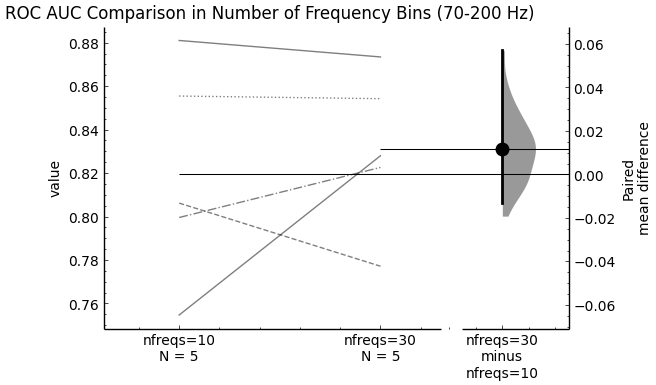

In [21]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "nfreqs=10": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "nfreqs=30": stratified_kf_scores_more_freq["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("nfreqs=10", "nfreqs=30"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="ROC AUC Comparison in Number of Frequency Bins (70-200 Hz)");

## Shrinking freq range to 70-110 Hz

In [22]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 110]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

In [23]:
hi_gamma = power.data
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_trimmed = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_trimmed.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

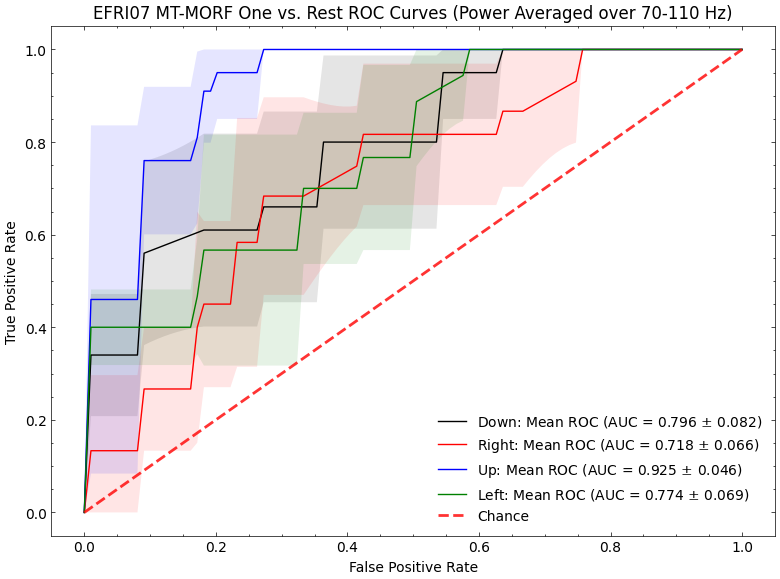

In [24]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_trimmed["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_trimmed["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-110 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

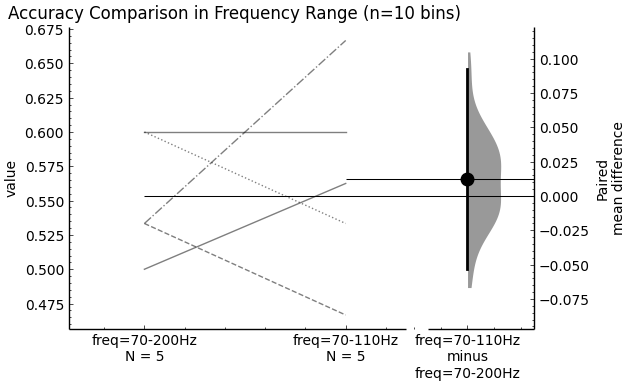

In [25]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_accuracy"],
    "freq=70-110Hz": stratified_kf_scores_trimmed["test_accuracy"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=70-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="Accuracy Comparison in Frequency Range (n=10 bins)");

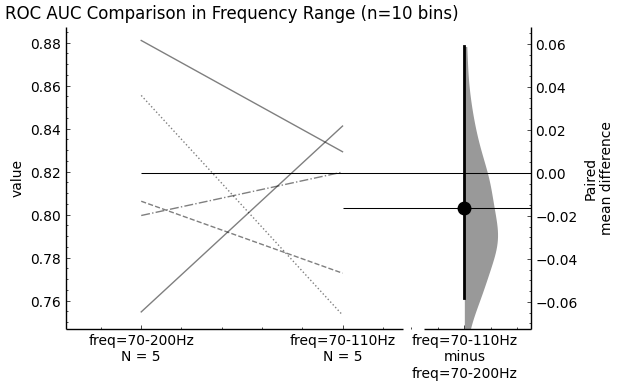

In [26]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "freq=70-110Hz": stratified_kf_scores_trimmed["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=70-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="ROC AUC Comparison in Frequency Range (n=10 bins)");

## 35-110 Hz

In [55]:
nfreqs = 10
freqs = np.logspace(*np.log10([35, 110]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

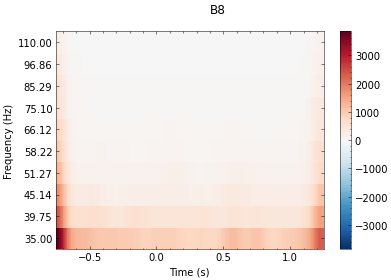

In [53]:
power.average().plot(["B7"]);

In [29]:
hi_gamma = power.data
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_trimmed = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_trimmed.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

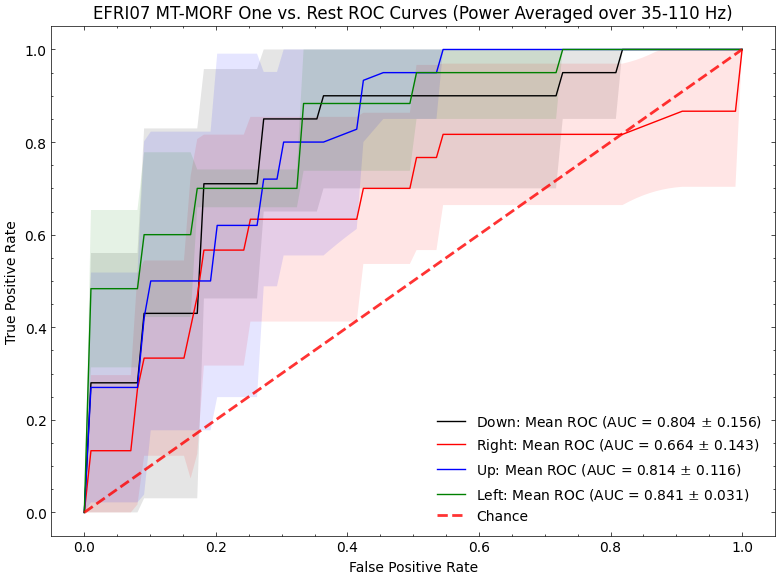

In [30]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_trimmed["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_trimmed["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 35-110 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

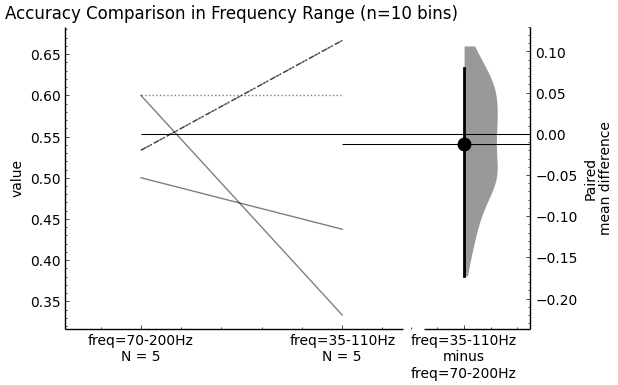

In [31]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_accuracy"],
    "freq=35-110Hz": stratified_kf_scores_trimmed["test_accuracy"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=35-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="Accuracy Comparison in Frequency Range (n=10 bins)");

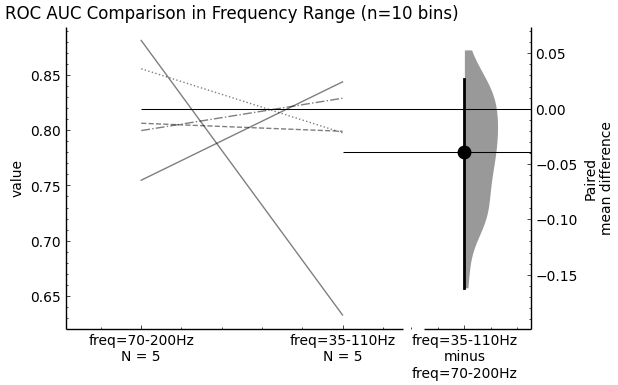

In [32]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "freq=35-110Hz": stratified_kf_scores_trimmed["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=35-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="ROC AUC Comparison in Frequency Range (n=10 bins)");

## Run on $N \times (C \times F) \times T$ data matrix (70-200 Hz)

In [33]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

hi_gamma = power.data

ntrials, nchs, nfreqs, nsteps = hi_gamma.shape

# structured to have all frequencies of one channel in consecutive rows
freq_data = hi_gamma.reshape(ntrials, nchs*nfreqs, nsteps)

times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
freq_data = freq_data[:, :, times]

In [34]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=freq_data.shape[1],
    image_width=freq_data.shape[2],
)

stratified_kf_scores_all_freq = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_all_freq.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

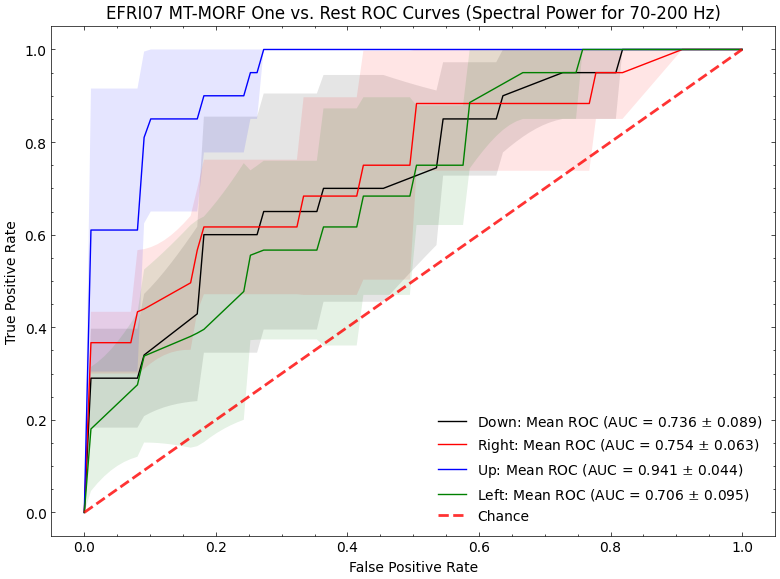

In [35]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_all_freq["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_all_freq["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Spectral Power for 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

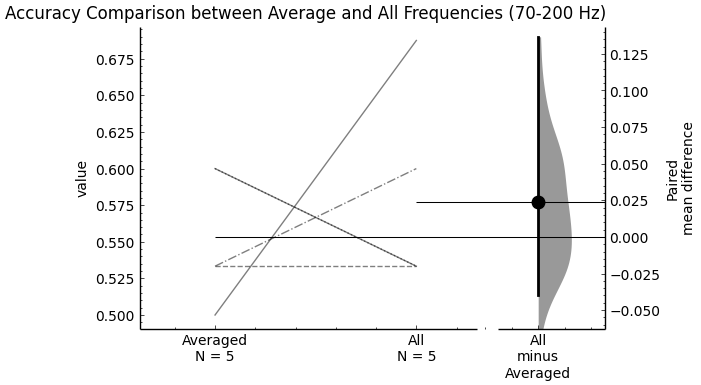

In [37]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "Averaged": stratified_kf_scores_freq_avg["test_accuracy"],
    "All": stratified_kf_scores_all_freq["test_accuracy"],
})

my_data = dabest.load(df, idx=("Averaged", "All"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="Accuracy Comparison between Average and All Frequencies (70-200 Hz)");

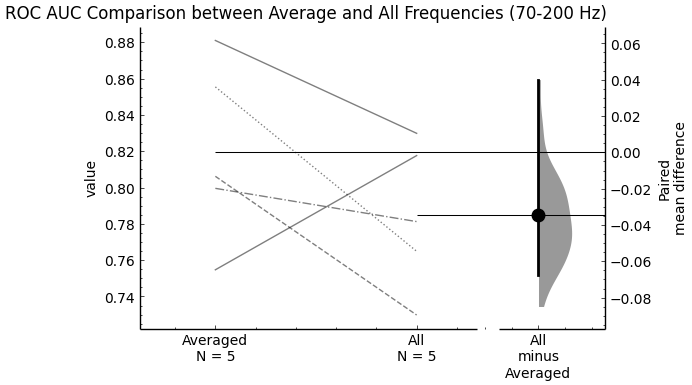

In [38]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "Averaged": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "All": stratified_kf_scores_all_freq["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("Averaged", "All"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="ROC AUC Comparison between Average and All Frequencies (70-200 Hz)");

## Run on $N \times (C \times F) \times T$ data matrix (35-110 Hz)

In [39]:
nfreqs = 10
freqs = np.logspace(*np.log10([35, 110]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

hi_gamma = power.data

ntrials, nchs, nfreqs, nsteps = hi_gamma.shape

# structured to have all frequencies of one channel in consecutive rows
freq_data = hi_gamma.reshape(ntrials, nchs*nfreqs, nsteps)

times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
freq_data = freq_data[:, :, times]

In [40]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=freq_data.shape[1],
    image_width=freq_data.shape[2],
)

stratified_kf_scores_all_freq_35_110 = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_all_freq_35_110.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

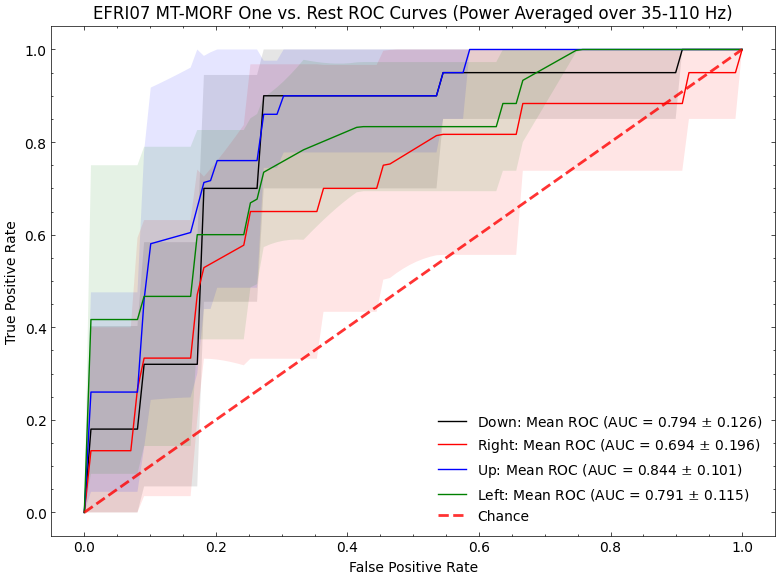

In [41]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_all_freq_35_110["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_all_freq_35_110["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 35-110 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

In [ ]:
## TODO: N x (CxF) x T data matrix
# Compare w/ prev experiments using DABEST
# Run1: nfreqs=10, l_freq=70, h_freq=200
# Run2: nfreqs=30, l_freq=70, h_freq=200
    # then think about what range will work
    # run on other subjects
# run full permutation importance on N x (CxF) x T data matrix
    # see what frequencies are meaningful
    # try ablating channels based on perm importance and rerun mtmorf
    # and do above spectral power comparisons
# overleaf outline - purpose, set of hypotheses + corresp experiments

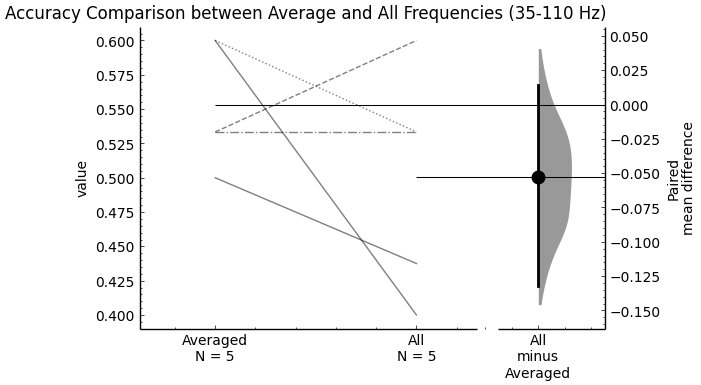

In [45]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "Averaged": stratified_kf_scores_freq_avg["test_accuracy"],
    "All": stratified_kf_scores_all_freq_35_110["test_accuracy"],
})

my_data = dabest.load(df, idx=("Averaged", "All"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="Accuracy Comparison between Average and All Frequencies (35-110 Hz)");

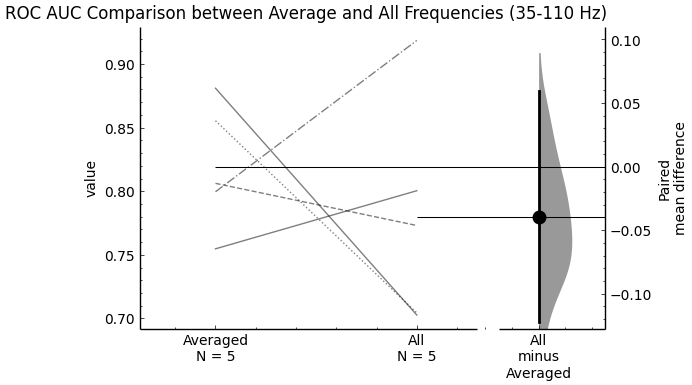

In [46]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "Averaged": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "All": stratified_kf_scores_all_freq_35_110["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("Averaged", "All"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="ROC AUC Comparison between Average and All Frequencies (35-110 Hz)");

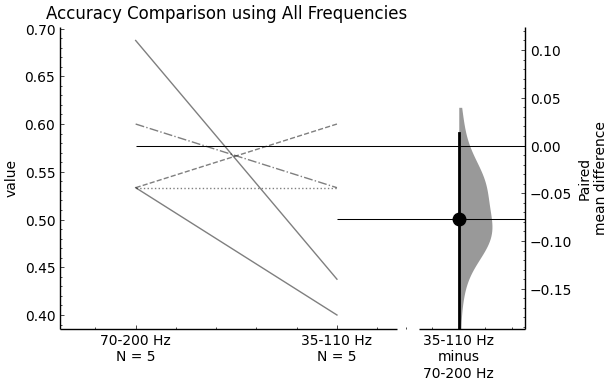

In [44]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "70-200 Hz": stratified_kf_scores_all_freq["test_accuracy"],
    "35-110 Hz": stratified_kf_scores_all_freq_35_110["test_accuracy"],
})

my_data = dabest.load(df, idx=("70-200 Hz", "35-110 Hz"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="Accuracy Comparison using All Frequencies");

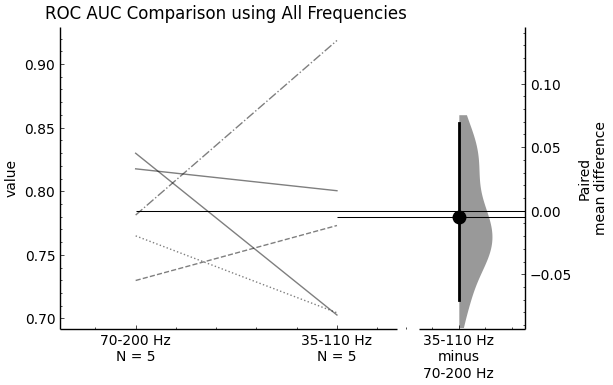

In [47]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "70-200 Hz": stratified_kf_scores_all_freq["test_roc_auc_ovr"],
    "35-110 Hz": stratified_kf_scores_all_freq_35_110["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("70-200 Hz", "35-110 Hz"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="ROC AUC Comparison using All Frequencies");

# EFRI02

In [26]:
# bids_root = Path("/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/data/efri/")

tmin, tmax = (-0.75, 1.25)

bids_root = Path("/workspaces/research/mnt/data/efri")
derivatives_path = (
    bids_root / "derivatives" / "preprocessed" / f"tmin={tmin}-tmax={tmax}" / "low-pass=1000Hz-downsample=500"
)

# subject identifiers
subject = "efri02"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".vhdr", root=bids_root)

In [27]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

Out of 135 trials, there were 132 successful trials in /workspaces/research/mnt/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 135 trials, there were 132 successful trials in /workspaces/research/mnt/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.


In [31]:
# get preprocessed epochs data
fname = os.path.splitext(bids_path.basename)[0] + "-epo.fif"
fpath = derivatives_path / subject / fname

epochs = mne.read_epochs(fpath, preload=True)
epochs = epochs.drop(unsuccessful_trial_inds)

## Average Spectral Power (70-200 Hz)

In [32]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

(105, 64, 10, 334)


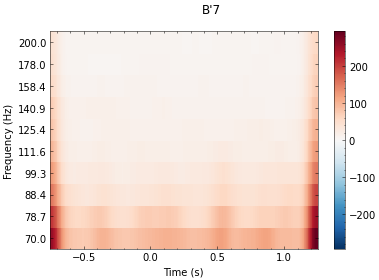

In [33]:
hi_gamma = power.data

print(hi_gamma.shape)

power.average().plot(["B'7"]);

In [34]:
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

# Perform K-Fold cross validation
n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_freq_avg = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_freq_avg.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

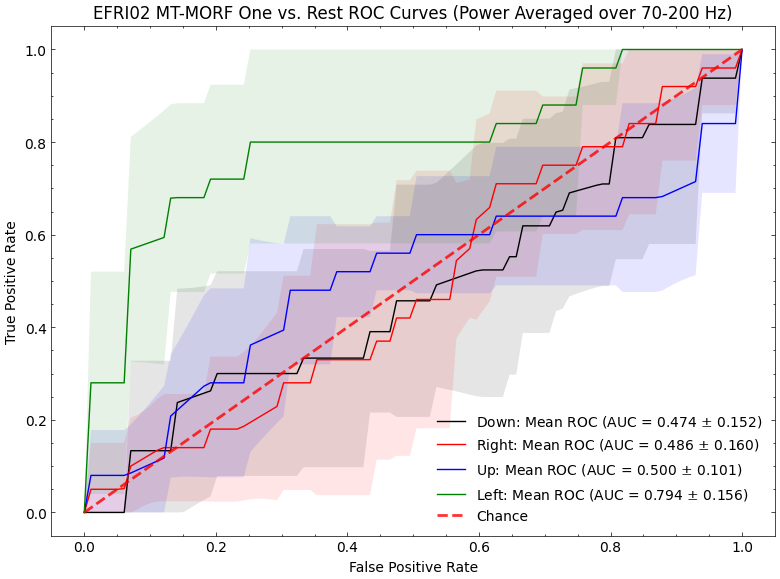

In [35]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_freq_avg["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_freq_avg["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

## Avg Spectral Power (35-110 Hz)

In [36]:
nfreqs = 10
freqs = np.logspace(*np.log10([35, 110]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

In [37]:
hi_gamma = power.data
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_avg_freq_35_110 = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_avg_freq_35_110.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

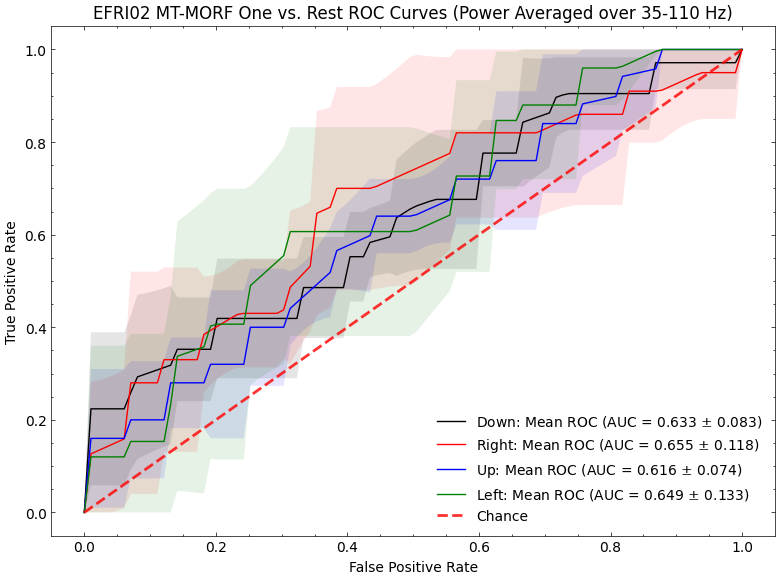

In [38]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_avg_freq_35_110["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_avg_freq_35_110["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 35-110 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

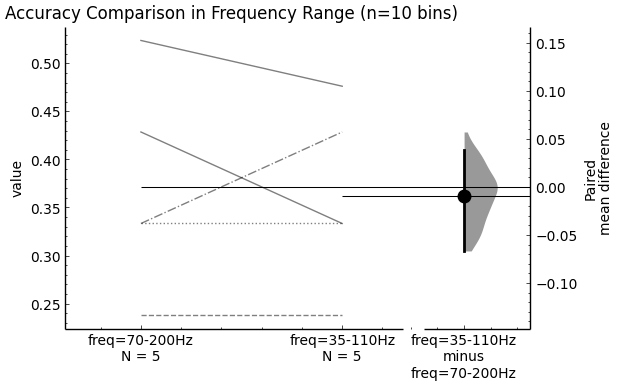

In [39]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_accuracy"],
    "freq=35-110Hz": stratified_kf_scores_avg_freq_35_110["test_accuracy"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=35-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="Accuracy Comparison in Frequency Range (n=10 bins)");

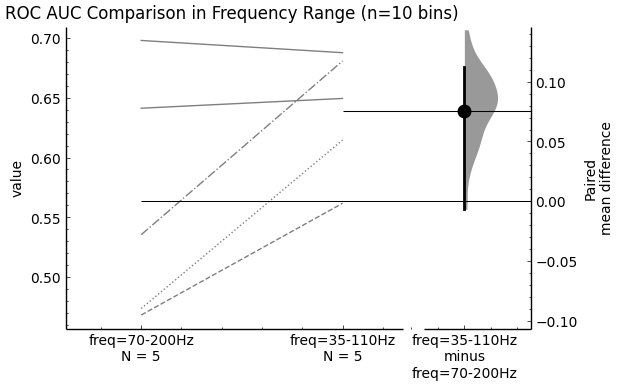

In [40]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "freq=35-110Hz": stratified_kf_scores_avg_freq_35_110["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=35-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="ROC AUC Comparison in Frequency Range (n=10 bins)");

## Run on $N \times (C \times F) \times T$ data matrix

In [ ]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

hi_gamma = power.data

ntrials, nchs, nfreqs, nsteps = hi_gamma.shape

# structured to have all frequencies of one channel in consecutive rows
freq_data = hi_gamma.reshape(ntrials, nchs*nfreqs, nsteps)

times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
freq_data = freq_data[:, :, times]

In [41]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=freq_data.shape[1],
    image_width=freq_data.shape[2],
)

stratified_kf_scores_all_freq = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_all_freq.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

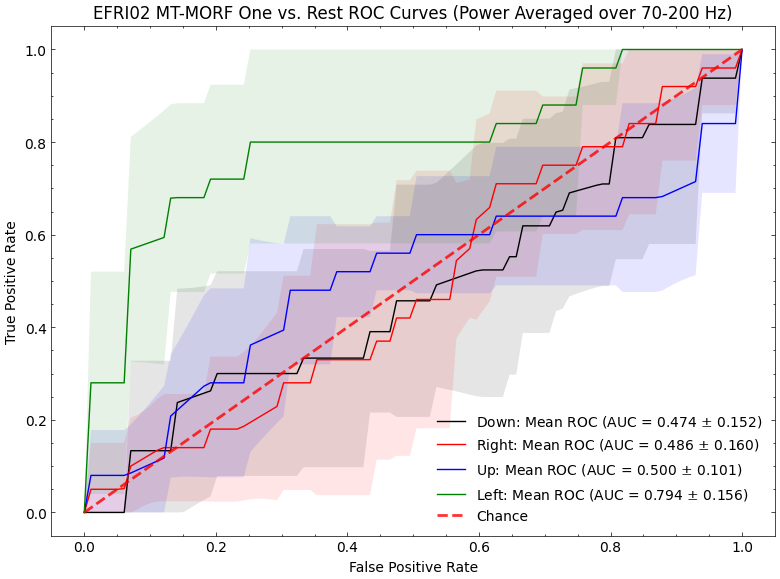

In [42]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_freq_avg["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_freq_avg["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

In [43]:
nfreqs = 10
freqs = np.logspace(*np.log10([35, 110]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

hi_gamma = power.data

ntrials, nchs, nfreqs, nsteps = hi_gamma.shape

# structured to have all frequencies of one channel in consecutive rows
freq_data = hi_gamma.reshape(ntrials, nchs*nfreqs, nsteps)

times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
freq_data = freq_data[:, :, times]

In [44]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=freq_data.shape[1],
    image_width=freq_data.shape[2],
)

stratified_kf_scores_all_freq = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_all_freq.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

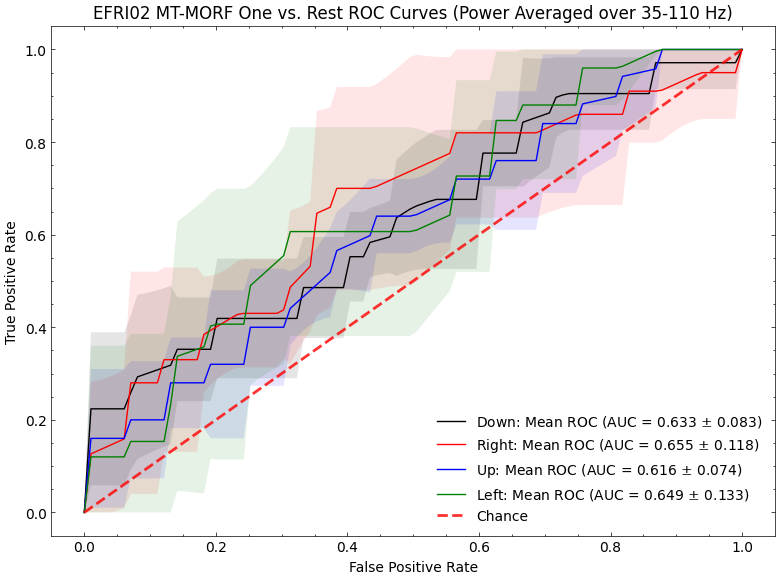

In [45]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_all_freq["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_all_freq["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 35-110 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();